# 深圳市出租车GPS数据分析

In [42]:
# 导入所有需要的包
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

## 1 出租车GPS数据读取与清洗

### 1.1 数据读取

该数据为深圳市一天时间内抽样500辆出租车的GPS数据，字段包括：车辆ID、经度、纬度、时间、载客状态与速度。

In [43]:
# 读取GPS数据文件，传入参数header避免第一行数据变成表格列名
data = pd.read_csv('./assets/data/TaxiData-Sample.csv', header=None)
# 由于数据没有列名，手动设置数据的列名为["车牌号", "时间", "经度", "纬度", "载客状态", "车速"]
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54
...,...,...,...,...,...,...
544994,28265,21:35:13,114.321503,22.709499,0,18
544995,28265,09:08:02,114.322701,22.681700,0,0
544996,28265,09:14:31,114.336700,22.690100,0,0
544997,28265,21:19:12,114.352600,22.728399,0,0


### 1.2 清洗异常数据

时空大数据中不存在完美的数据，任何数据都存在异常。

#### 1.2.1 载客状态字段异常

数据中的载客状态 `OpenStatus` 字段表征了出租车载客状态。当值为 `1` 时，表示出租车有乘客，为载客状态；反之则为空载状态。如果将所有的车辆数据读取在一个表中，将数据按车牌号和时间排序，那么在理想状态下，一辆出租车正常的 `OpenStatus` 序列应该连续 `0` 序列和连续 `1` 序列依次出现。

当 `OpenStatus` 的值由 `A` 时刻的 `0` 变为 `B` 时刻的 `1` 时，代表乘客在 `A` 时刻与 `B` 时刻中间的某一时刻上车，运营开始。同样，当 `OpenStatus` 的值由 `C` 时刻的 `1` 变为 `D` 时刻的 `0` 时，代表乘客在 `C` 时刻与 `D` 时刻中间的某一时刻下车，运营结束。由于出租车的采样频率约为 `15s` 一次，可以近似地认为相邻采样点在时间和空间上十分相近， `A` 、 `B` 两个时刻都可以看成乘客的上车点；同样地， `C` 时刻和 `D` 时刻都可以看成下车点。为了数据处理的方便，统一把 `A` 时刻看成乘客的上车点， `C` 时刻看成乘客的下车点。

但是 `OpenStatus` 字段中可能会出现异常情况：

- 在连续 `0` 的序列中，突然出现一个 `1` 。如果用刚才判断乘客上下车处理逻辑，异常数据会导致乘客上下车点连续的两条记录，如果没有剔除，后续的出行OD分析中则会表现为在同一地点上下车。
- 在连续 `1` 的序列中，突然出现一个 `0` 。不排除某些出租车司机生意火爆，上一个订单结束后来不及休息就可以马不停蹄地开始下一单。但考虑到GPS数据 `15s` 的采样间隔，要在 `15~30s` 的时间内实现一个乘客付钱、下车，另一个乘客上车、关上车门、开始打表的一系列过程，对两个乘客来说可能是难度系数较高的操作，可以认为这是一种小概率事件。

这两种情况的产生都极有可能是采集设备的突发异常造成的，在数据清洗中，应将这两种情况都予以剔除。

#### 1.2.2 数据清洗思路

如何剔除上面提到的两种数据异常呢？我们可以很容易地说出这两种异常都具有的共同特征：

- 异常数据的载客状态与前一条数据和后一条数据的值均不同。
- 这三条数据必须是同一辆出租车的连续数据。

也就是，程序只需要找到符合上述特征的数据，并将其剔除即可。如果将上面的条件总结成为程序中判断条件，则为：

- 异常数据的 `OpenStatus` 与前一条数据不等。
- 异常数据的 `OpenStatus` 与后一条数据不等。
- 异常数据的 `VehicleNum` 与前一条数据的 `VehicleNum` 相等。
- 异常数据的 `VehicleNum` 与后一条数据的 `VehicleNum` 相等。

将上面的这四个条件用 `&` 连接起来，所判断的即为异常数据，而将异常数据剔除，就完成了清洗。

#### 1.2.3 数据排序与异常数据剔除

In [44]:
# 对数据按照车牌与GPS时间进行排序，让同一辆车的数据放在一起，且按照时间大小排序。
data = data.sort_values(by=['VehicleNum', 'Stime'])
# 将数据的前一行和后一行的信息都放在了同一行上，以两个新的字段表示，用于判断。
# 将OpenStatus列整体下移一行，赋值给OpenStatus1列
data['OpenStatus1'] = data['OpenStatus'].shift()
# 将OpenStatus列整体上移一行，赋值给OpenStatus2列
data['OpenStatus2'] = data['OpenStatus'].shift(-1)
# 将VehicleNum列整体下移一行，赋值给VehicleNum1列
data['VehicleNum1'] = data['VehicleNum'].shift()
# 将VehicleNum列整体下移一行，赋值给VehicleNum2列
data['VehicleNum2'] = data['VehicleNum'].shift(-1)
# 剔除异常数据
data = data[-((data['OpenStatus'] != data['OpenStatus1']) &  # 条件一
              (data['OpenStatus'] != data['OpenStatus2']) &  # 条件二
              (data['VehicleNum'] == data['VehicleNum1']) &  # 条件三
              (data['VehicleNum'] == data['VehicleNum2']))]  # 条件四
# 删除辅助判断的列，用axis=1指定使用列名删除
data = data.drop(['OpenStatus1', 'OpenStatus2', 'VehicleNum1', 'VehicleNum2'], axis=1)
# 结果保存，保存数据到指定路径，index关键字决定是否保存行名
data.to_csv('./assets/data/TaxiData-Clean.csv', index=None, encoding='utf-8_sig')
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
20280,22396,00:00:29,113.996719,22.693333,1,20
19577,22396,00:01:01,113.995514,22.695032,1,34
19985,22396,00:01:09,113.995430,22.695766,1,41
19153,22396,00:01:41,113.995369,22.696484,1,0
19986,22396,00:02:21,113.995430,22.696650,1,17
...,...,...,...,...,...,...
177680,36805,23:53:21,114.120354,22.544300,1,0
182105,36805,23:53:27,114.120354,22.544300,1,0
178293,36805,23:53:33,114.120354,22.544300,1,0
177982,36805,23:53:36,114.120354,22.544300,0,0


## 2 出租车数据的完整性评估

### 2.1 如何评估数据质量

可以从数据的基本特征、数据的完整性和准确性等方面初步评估手中的数据质量：

1. **数据的基本特征**。对数据基本特征的分析，应关注数据能够反映样本的什么特征。例如，对于出租车数据，首先需要关注的是GPS设备的采样频率。不同采样频率的数据，能够做的事情是不同的，例如，目前手上的数据采样频率约为 `15s` 一条，此时可以分析出行的OD信息、车辆的运行速度、交叉口的延误等；如果采样粒度更精细， `1s` 一条，那么可以用来分析车辆的运行工况、加减速等；反之，如果采样粒度粗糙， `1 ~ 2h` 一条，那么可能只能用来分析车辆大致的分布、出行的热点分布。
2. **数据的完整性**。对数据的完整性，首先观察数据本身的内容是否存在缺失值。在出租车数据中，需要检查每一条出租车数据是否有经纬度、时间、运营状态等，不存在缺失值。如果存在缺失值，数据的缺失率是多少？能否补全数据，如何补全？删除缺失数据是否会影响分析结果？对时空大数据，数据的完整性还得考虑个体、时间与空间维度。在个体维度上，需要回答：数据是抽样数据还是全样本数据？如果是抽样数据，数据量是多少？怎么抽样？抽样率是多少？抽样数据在时空上有什么特征？数据是城市中一家出租车运营公司的数据还是所有出租车运营公司的数据总和？在时间维度上，数据是否在某段时间内存在缺失？这种缺失是因为数据采集出现问题，还是数据本身在这一时段内就比较少？在空间维度上，数据是否在某个地理域范围内存在缺失？是这里本身就处于郊区没采集到样本，还是这里的GPS信号因为某种故障而丢失？
3. **数据的准确性**。数据的准确性则是评估数据与真实情况的差异。例如，某市的出租车数据经纬度是否在该市的地理范围内？如果超出该市的地理范围，超出距离大概是多少？更细来说，出租车应该出现在道路上，不可能出现在建筑物里，那么数据能否很准确地分布在道路上？数据的地理位置是否存在瞬移？出租车的车速是否在合理范围，若车速为负值或者超出城市运营管理速度的上限，那就有理由怀疑这些速度的准确性。

### 2.2 出租车数据的时间完整性评估

本节以出租车数据的时间维度完整性为例进行质量评估，统计数据在时间上的分布情况。数据的时间统计粒度不同，会导致最后统计的结果出现一定差异。因此，需要根据研究目的，确定与其相适应的时间统计单位。在本节中，将以小时为粒度，统计出租车GPS数据与出行订单数量的小时分布情况。

时空大数据的时间信息可能包括年、月、日、时、分、秒等时间单位，而在读取数据时，如果没有设定时间格式，读取进来的时间字段的值将以字符串形式呈现，我们手中数据的时间格式与统计粒度并不能够完全重合。因此，如果需要统计每小时出租车的GPS数据量与出行订单数量，需要从时间字段中提取出小时的信息，作为数据表中的一列，并将以此列为依据进行统计。

因此，这里的核心工作是如何从时间字段中提取出小时信息以及如何基于小时信息统计每小时的数据量。

#### 2.2.1 时间字段的处理

把 `Series` 对象转换为 `pandas` 内置的 `StringMethods` 对象，并使用 `StringMethods` 对象的 `slice` 方法截取字符串切片，传入开始与结束位置的索引，提取前两位字符，从而获取小时信息。

采用 `StringMethods` 对象的方法，可以对原有 `Series` 的每一行进行相同的字符串操作，输出结果为 `Series` 形式。其中的过程可以理解为 `StringMethods` 对象的方法对原 `Series` 的每一行元素遍历操作，将所有行的结果按照原有 `Series` 的 `Index` 排序，构成一个 `Series` 后输出。


In [45]:
# 把Stime列转化为StringMethods对象，进行切片操作，在赋值给Hour列
data['Hour'] = data['Stime'].str.slice(0, 2)
# 提取出的结果为字符串类型，需要转换为数值型
data['Hour'] = data['Hour'].astype(int)
data

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed,Hour
20280,22396,00:00:29,113.996719,22.693333,1,20,0
19577,22396,00:01:01,113.995514,22.695032,1,34,0
19985,22396,00:01:09,113.995430,22.695766,1,41,0
19153,22396,00:01:41,113.995369,22.696484,1,0,0
19986,22396,00:02:21,113.995430,22.696650,1,17,0
...,...,...,...,...,...,...,...
177680,36805,23:53:21,114.120354,22.544300,1,0,23
182105,36805,23:53:27,114.120354,22.544300,1,0,23
178293,36805,23:53:33,114.120354,22.544300,1,0,23
177982,36805,23:53:36,114.120354,22.544300,0,0,23


#### 2.2.2 数据量的小时统计

接下来，如何基于小时信息统计每小时的数据量？通过前面时间字段中的小时信息的提取，同一小时内产生的GPS数据， `Hour` 字段中会拥有相同的值，可以依据这一字段对数据采用 `groupby` 方法进行集计操作，再用 `count` 方法指定 `VehicleNum` 列统计每小时的数据量。

In [46]:
# 分组并统计各组数量
Hourcount = data.groupby('Hour')['VehicleNum'].count()
# 更改Series的列名，并将通过reset_index将Series变成DataFrame
Hourcount = Hourcount.rename('count').reset_index()
Hourcount

,Hour,count
0,0,23701
1,1,22312
2,2,21235
3,3,20019
4,4,19682
5,5,20068
6,6,19533
7,7,22388
8,8,23789
9,9,22001


#### 2.2.3 数据量时间分布图绘制

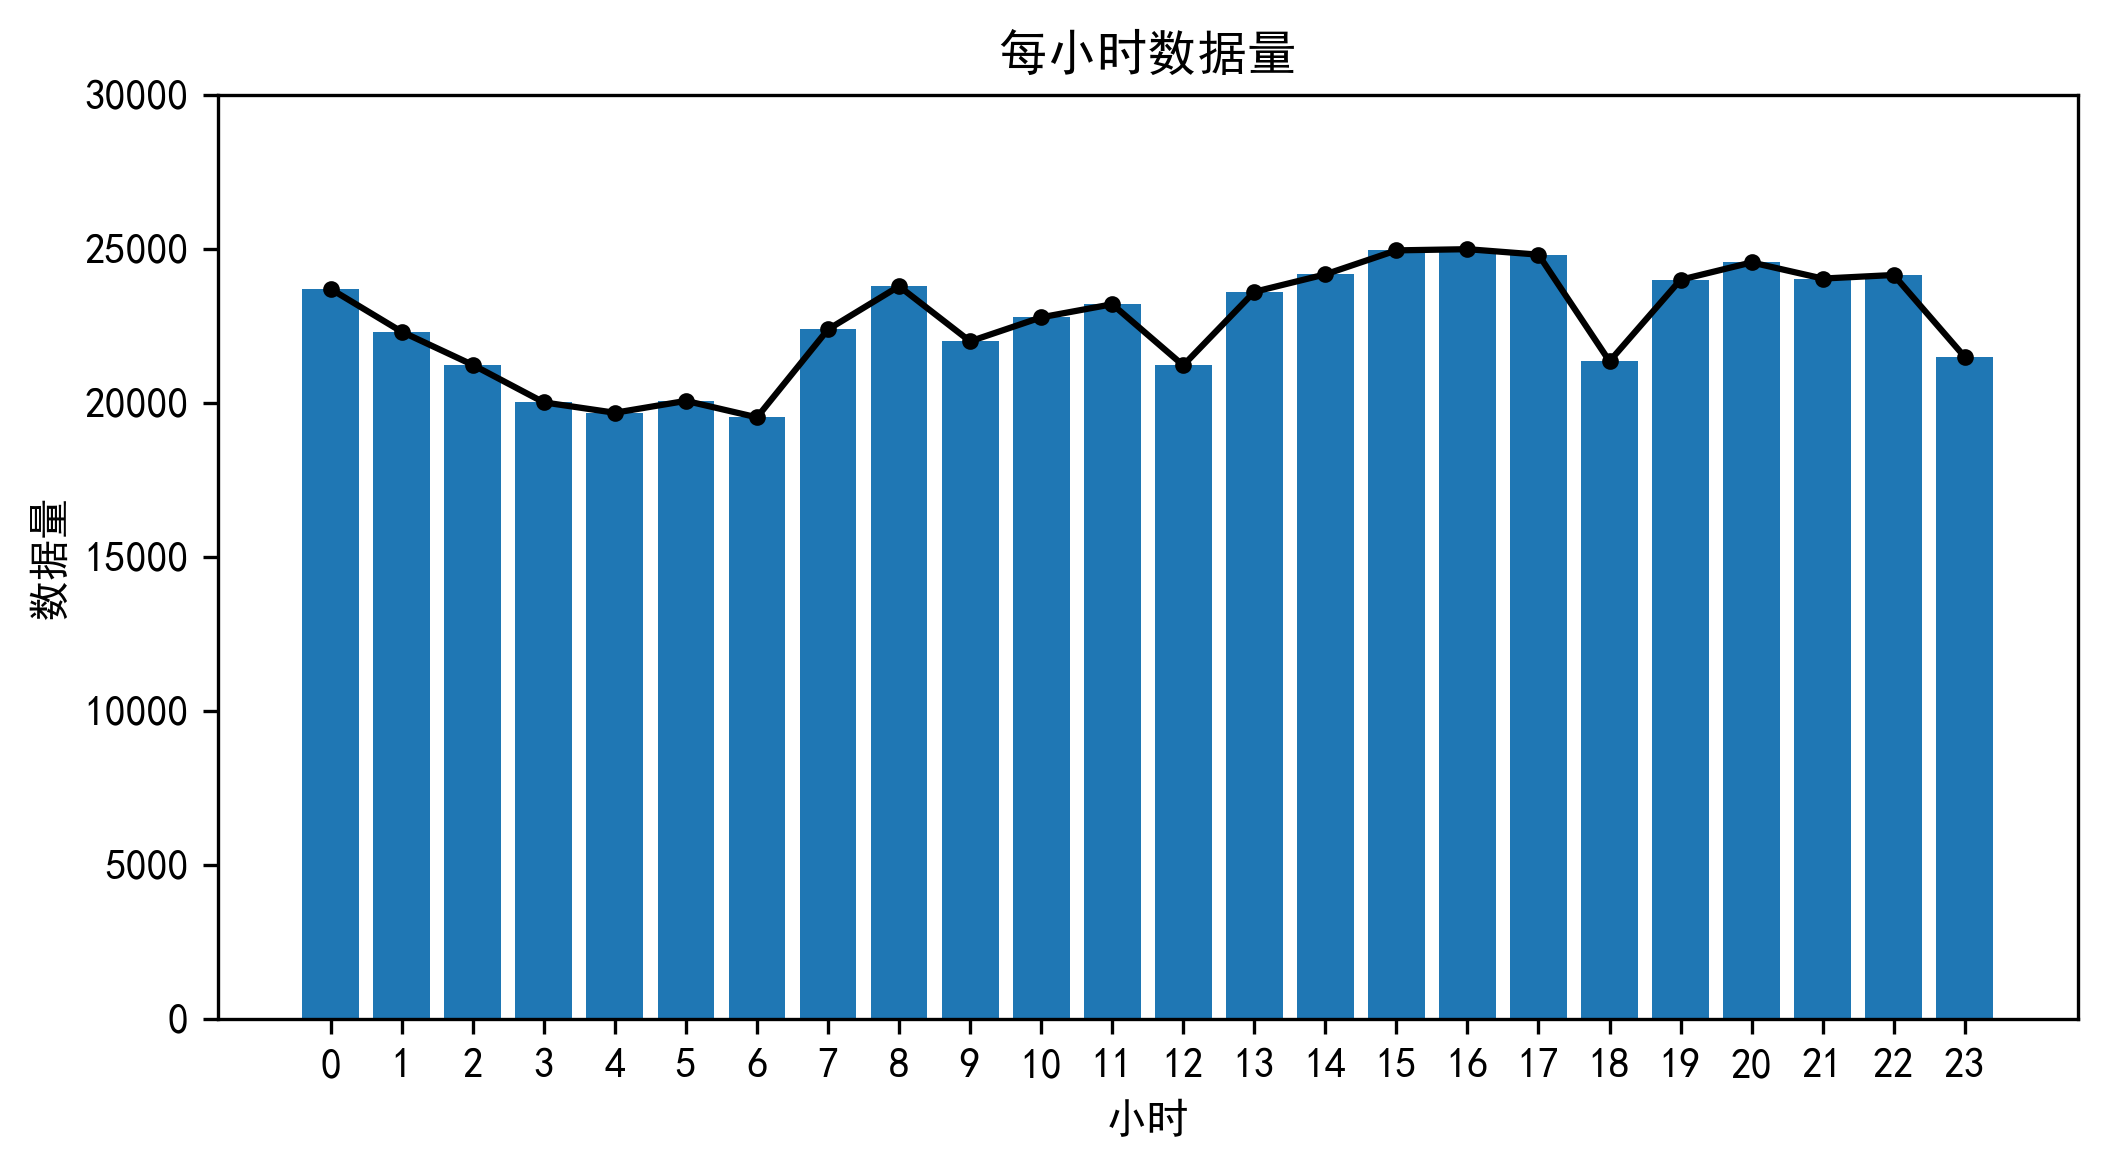

In [47]:
# 创建一个图,图的尺寸为8×4,dpi为300
fig = plt.figure(1, (8, 4), dpi=300)
# 在图中创建子图
# 111分别表示：创建共一个子图，子图的布局为1行1列
ax = plt.subplot(111)
# 绘制折线图，线为黑色实线
plt.plot(Hourcount['Hour'], Hourcount['count'], 'k-')
# 绘制散点图，每个数据点为黑色
plt.plot(Hourcount['Hour'], Hourcount['count'], 'k.')
# 绘制柱状图
plt.bar(Hourcount['Hour'], Hourcount['count'])
# 加y轴标题
plt.ylabel('数据量')
# 加x轴标题
plt.xlabel('小时')
# 调整x轴标签
plt.xticks(range(24), range(24))
# 加图标题
plt.title('每小时数据量')
# 设置y轴范围
plt.ylim(0, 30000)
# 显示图
plt.show()

### 2.3 出租车数据的空间完整性评估

#### 2.3.1 出租车GPS数据空间分布栅格图

##### 2.3.1.1 生成研究区域栅格

In [48]:
# 读取shp格式地理数据文件，读.shp
sz = gpd.GeoDataFrame.from_file(r'./assets/data/sz/sz.shp', encoding='utf8')
# 定义研究范围与栅格大学，计算△log与△lat
# 划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748
# 取得左下角的经纬度
latStart = min(lat1, lat2)
lonStart = min(lon1, lon2)
# 定义栅格大小，单位为米
accuracy = 500
# 计算栅格的经纬度增加量大小△Lon和△Lat，地球半径取6371004米
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360))
deltaLat = accuracy * 360 / (2 * math.pi * 6371004)
# 计算每个栅格的四个顶点坐标，循环生成栅格，生成整个研究范围的栅格
# 定义空的GeoDataFrame表，再往里加栅格
data = gpd.GeoDataFrame()
# 定义空的list，后面循环一次就往里面加东西
LONCOL_list = []
LATCOL_list = []
geometry_list = []
HBLON_list = []
HBLAT_list = []
# 计算行列要生成的栅格数量
# lon方向是lonsnum个栅格
lonsnum = int((lon2 - lon1) / deltaLon) + 1
# lat方向是latsnum个栅格
latsnum = int((lat2 - lat1) / deltaLat) + 1
for i in range(lonsnum):
    for j in range(latsnum):
        #第i列，第j行的栅格中心点坐标
        HBLON = i * deltaLon + lonStart
        HBLAT = j * deltaLat + latStart
        #用周围的栅格推算三个顶点的位置
        HBLON_1 = (i + 1) * deltaLon + lonStart
        HBLAT_1 = (j + 1) * deltaLat + latStart
        #生成栅格的Polygon形状
        grid_ij = Polygon([
            (HBLON - deltaLon / 2, HBLAT - deltaLat / 2),
            (HBLON_1 - deltaLon / 2, HBLAT - deltaLat / 2),
            (HBLON_1 - deltaLon / 2, HBLAT_1 - deltaLat / 2),
            (HBLON - deltaLon / 2, HBLAT_1 - deltaLat / 2)])
        #把生成的数据都加入到前面定义的空list里面
        LONCOL_list.append(i)
        LATCOL_list.append(j)
        HBLON_list.append(HBLON)
        HBLAT_list.append(HBLAT)
        geometry_list.append(grid_ij)
# 为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL_list
data['LATCOL'] = LATCOL_list
data['HBLON'] = HBLON_list
data['HBLAT'] = HBLAT_list
data['geometry'] = geometry_list
data

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.751940,22.447837,"POLYGON ((113.74950 22.44559, 113.75438 22.445..."
1,0,1,113.751940,22.452334,"POLYGON ((113.74950 22.45009, 113.75438 22.450..."
2,0,2,113.751940,22.456830,"POLYGON ((113.74950 22.45458, 113.75438 22.454..."
3,0,3,113.751940,22.461327,"POLYGON ((113.74950 22.45908, 113.75438 22.459..."
4,0,4,113.751940,22.465823,"POLYGON ((113.74950 22.46358, 113.75438 22.463..."
...,...,...,...,...,...
16735,179,88,114.624138,22.843538,"POLYGON ((114.62170 22.84129, 114.62657 22.841..."
16736,179,89,114.624138,22.848035,"POLYGON ((114.62170 22.84579, 114.62657 22.845..."
16737,179,90,114.624138,22.852531,"POLYGON ((114.62170 22.85028, 114.62657 22.850..."
16738,179,91,114.624138,22.857028,"POLYGON ((114.62170 22.85478, 114.62657 22.854..."


<Axes: >

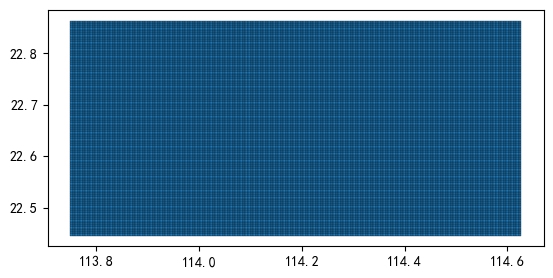

In [49]:
# 绘制栅格的空间分布
data.plot(edgecolor=(0, 0, 0, 1), linewidth=0.2)

<Axes: >

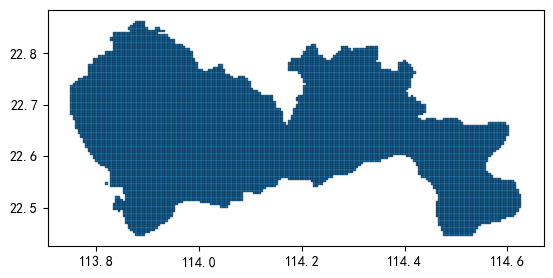

In [50]:
# 将前面读取的GeoDataFrame用unary_union方法合并为一个Polygon图形作为研究范围
roi = sz.unary_union
# 输入行政区划的Polygon，利用GeoDataFrame的intersects方法，筛选出研究范围的栅格，将行政区划外的栅格剔除
grid_sz = data[data.intersects(roi)]
grid_sz.plot(edgecolor=(0, 0, 0, 1), linewidth=0.2)

In [51]:
# 将数据保存到本地
grid_sz.to_file(r'./assets/data/grid_sz.json', driver='GeoJSON')

##### 2.3.1.2 GPS数据的栅格对应与统计

GPS数据以经纬度坐标的形式记录，计算每个GPS点对应的栅格编号，然后基于栅格编号统计每个栅格内GPS数据量。

In [53]:
# 读取数据
data = pd.read_csv('./assets/data/TaxiData-Sample.csv', header=None)
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']
# 数据对应的栅格经纬度编号
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2)) / deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2)) / deltaLat).astype('int')
# 集计栅格数据量
data_distribution = data.groupby(['LONCOL', 'LATCOL'])['VehicleNum'].count().rename('count').reset_index()
# 剔除不在研究范围内的OD记录
data_distribution = data_distribution[(data_distribution['LONCOL'] >= 0) & (data_distribution['LATCOL'] >= 0) &
                                      (data_distribution['LONCOL'] <= lonsnum) & (
                                                  data_distribution['LATCOL'] <= latsnum)]
data_distribution

,LONCOL,LATCOL,count
188,0,77,1
189,0,78,7
190,0,81,4
192,1,77,3
193,1,78,1
...,...,...,...
3968,160,89,2
3969,162,91,2
3970,163,92,1
3971,164,93,2


##### 2.3.1.3 统计结果与栅格连接

##### 2.3.1.4 栅格数据分布可视化